In [121]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from src.processing.relation_extraction_evaluator import RelationExtractorEvaluator, RelationGranularMetrics, config

evaluator = RelationExtractorEvaluator()

# Define path for the test dataset
data_stem="dialog-re-llama-11cls-2spkr-balPairs"
test_file_path = f"/home/murilo/RelNetCare/data/processed/{data_stem}/{data_stem}-test.json"

# Evaluate performance
df = evaluator.assess_performance_on_test_dataset(test_file_path, cap_size=None, return_details=True)
# print(results['overall'])

  0%|          | 0/66 [00:00<?, ?it/s]


Script successfully executed!
Avg P: 28.3% | Avg R: 27.5% | Avg F1: 27.8% | Errors: 6/66 (9%)
# INFERENCE REPORT
/home/murilo/RelNetCare/data/processed/dialog-re-llama-11cls-2spkr-balPairs/dialog-re-llama-11cls-2spkr-balPairs-test_20230901_110851.xlsx



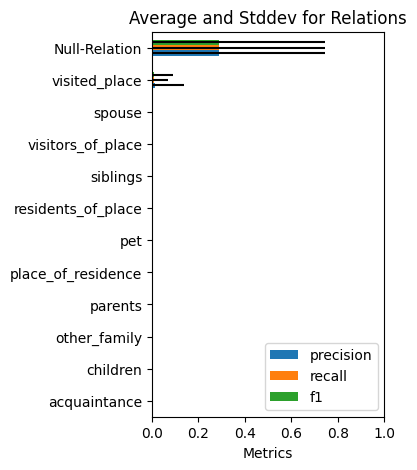

In [17]:

# Define your ontology
your_ontology = {
    "Null-Relation", "other_family", "siblings",
    "visited_place", "place_of_residence",
    "spouse", "pet", "acquaintance", "children",
    "visitors_of_place", "residents_of_place", "parents"
    }

# Usage
my_metrics = RelationGranularMetrics(df, your_ontology)
result = my_metrics.process()
chart_df = my_metrics.to_dataframe()
my_metrics.plot_metrics(chart_df)


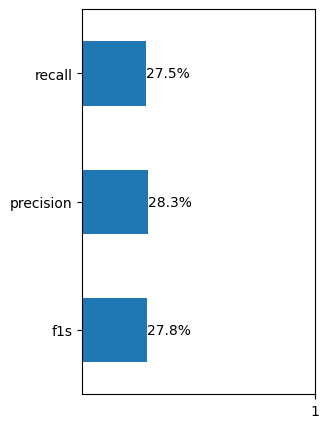

In [10]:
import matplotlib.pyplot as plt

# Your plotting code here
ax = df[['f1s', 'precision', 'recall']].mean().plot(kind='barh', alpha=1, figsize=(3, 5))

# Set x-axis tick labels
plt.xticks([1], ['1'])

# Adding data values on top of each bar
for bar in ax.patches:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1%}', 
             va='center', ha='left')

# Show the plot
plt.show()


<Axes: ylabel='Frequency'>

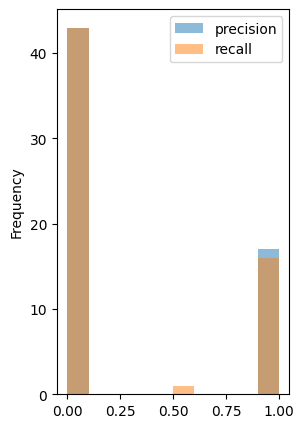

In [15]:
df[['precision', 'recall', 'f1s']].plot(kind='hist', alpha=0.5, figsize=(3, 5))


In [25]:
# dialogue = 'Speaker 1: Hi, you are my father.\nSpeaker 2: Yes, I am your father'
# dialogue = 'Speaker 1: I went to Maryland.\nSpeaker 2: Why?\nSpeaker 1: I work at Google there.'
dialogue = 'Speaker 1: I love my husband.\nSpeaker 2: Sweet! What is his name?\nSpeaker 1: John.'
# dialogue = 'Speaker 1: I love my husband.\nSpeaker 2: Sweet! '
jsonl = evaluator.infer_from_model(dialogue, preprompt=config.preprompt)
print(dialogue)

try:
    print(jsonl.replace('},', '},\n'))
except Exception as e:
    print(f'Exception={e}')
    print(jsonl)

Speaker 1: I love my husband.
Speaker 2: Sweet! What is his name?
Speaker 1: John.
[{"x": "John", "x_type": "PER", "r": "spouse", "y": "Speaker 1", "y_type": "PER"},
 {"x": "Speaker 1", "x_type": "PER", "r": "spouse", "y": "John", "y_type": "PER"}]
